# Milestone 2

In [ ]:
%cd ..
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scripts_m2 import *


/usr/local/lib/python3.11/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

### 1. Exploring the Dataset

In [5]:
# Loading the training data
import json

with open('data/m2_train.json', 'r') as f:
    squad_data = json.load(f)

print(squad_data['data'][0]['paragraphs'][0].keys())

print(json.dumps(squad_data['data'][0], indent=2))

dict_keys(['qas', 'context'])
{
  "title": "Beyonc\u00e9",
  "paragraphs": [
    {
      "qas": [
        {
          "question": "When did Beyonce start becoming popular?",
          "id": "56be85543aeaaa14008c9063",
          "answers": [
            {
              "text": "in the late 1990s",
              "answer_start": 269
            }
          ],
          "is_impossible": false
        },
        {
          "question": "What areas did Beyonce compete in when she was growing up?",
          "id": "56be85543aeaaa14008c9065",
          "answers": [
            {
              "text": "singing and dancing",
              "answer_start": 207
            }
          ],
          "is_impossible": false
        },
        {
          "question": "When did Beyonce leave Destiny's Child and become a solo singer?",
          "id": "56be85543aeaaa14008c9066",
          "answers": [
            {
              "text": "2003",
              "answer_start": 526
            }
          ],


In [6]:
# Counting the number of answerable and unanswerable questions
num_answerable = 0
num_unanswerable = 0

for article in squad_data["data"]:
    for paragraph in article["paragraphs"]:
        for qa in paragraph["qas"]:
            if qa["is_impossible"]:
                num_unanswerable += 1
            else:
                num_answerable += 1

print("Number of answerable questions: ", num_answerable)
print("Number of unanswerable questions: ", num_unanswerable)
print("Number of QA pairs: ", num_answerable + num_unanswerable)

Number of answerable questions:  86821
Number of unanswerable questions:  43498
Number of QA pairs:  130319


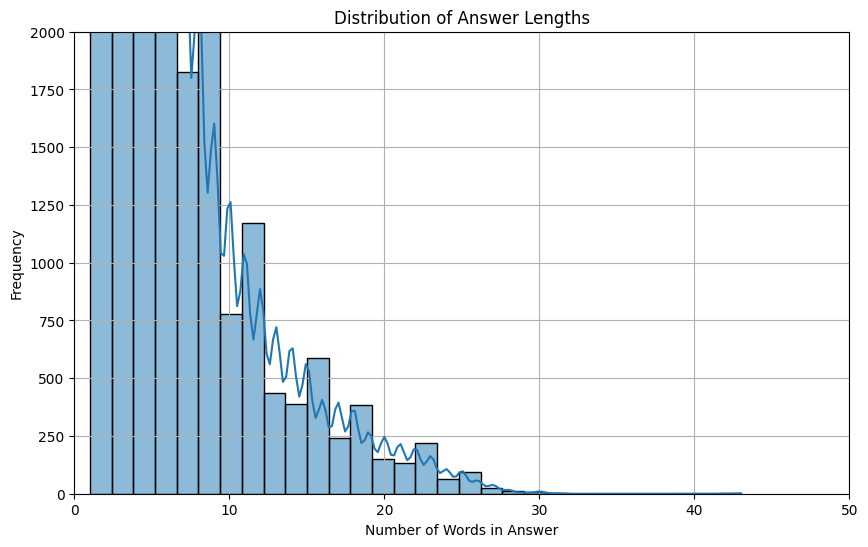

In [7]:
answer_lengths = []
for article in squad_data["data"]:
    for paragraph in article["paragraphs"]:
        for qa in paragraph["qas"]:
            if not qa["is_impossible"]:
                answer = qa["answers"][0]["text"]
                answer_lengths.append(len(answer.split()))
# Plotting the distribution of answer lengths
plt.figure(figsize=(10, 6))
sns.histplot(answer_lengths, bins=30, kde=True)
plt.title("Distribution of Answer Lengths")
plt.xlabel("Number of Words in Answer")
plt.ylabel("Frequency")
plt.xlim(0, 50)
plt.ylim(0, 2000)
plt.grid()
plt.show()

Answerable vs. Unanswerable Questions in SQuAD 2.0

- **Answerable Questions:** The correct answer exists within the given passage, and the model must extract the exact span.
- **Unanswerable Questions:** The passage does not contain the answer, and the model should predict "No Answer."

SQuAD 2.0 introduces unanswerable questions to make the task more challenging, requiring models to distinguish between when an answer is present and when it is not.

In this notebook, we will use answerable questions only in the subset we will be training our neural networks on

### 2. Preprocessing the dataset

In [8]:
# Clean text function
import re

def clean_text(text: str, is_question: bool=False):
    """
    Cleans text by removing extra spaces, newline characters, and special symbols.
    """
    if is_question:
        text = text.replace("\n", " ").replace("\t", " ")  # Remove newlines & tabs
        text = re.sub(r"\s+", " ", text)  # Remove extra spaces
        text = text.strip()  # Trim leading/trailing spaces
    text = text.lower()  # Convert to lowercase
    return text

# Testing the clean_text function on a sample text
sample_text = "   This is a \n\n\t sample    text.    "
print("Original text:", sample_text)
print("Cleaned text:", clean_text(sample_text))

Original text:    This is a 

	 sample    text.    
Cleaned text:    this is a 

	 sample    text.    


In [55]:
# Load and process the SQuAD dataset using the clean_text function
import json

def load_and_process_squad(filepath, max_samples=20000):
    """
    Loads, cleans, and extracts answerable questions from the SQuAD dataset.

    Args:
        filepath (str): Path to the SQuAD JSON file.
        max_samples (int): Maximum number of answerable questions to load.

    Returns:
        List[dict]: A list of cleaned question-answer pairs.
    """
    with open(filepath, "r") as f:
        squad_data = json.load(f)

    data = []
    for article in squad_data["data"]:
        for paragraph in article["paragraphs"]:
            context = clean_text(paragraph["context"])
            for qa in paragraph["qas"]:
                if qa["is_impossible"]:
                    continue

                question = clean_text(qa["question"], is_question=True)
                answer_text = clean_text(qa["answers"][0]["text"])
                answer_start = qa["answers"][0]["answer_start"]

                data.append({
                    "context": context,
                    "question": question,
                    "answer": answer_text,
                    "answer_start": answer_start,
                    "answer_end": answer_start + len(answer_text)})


    data.sort(key=lambda x: (len(x["answer"]),len(x["context"]), len(x["question"])))
    # Limit the number of samples if specified
    if max_samples > 0:
        data = data[:max_samples]
    return data

# Load and process the SQuAD dataset
train_dataset = load_and_process_squad("data/m2_train.json", max_samples=-1)
dev_samples = load_and_process_squad("data/m2_dev.json", max_samples=2000)

print("Number of QA pairs in train data:", len(train_dataset))
print("Training sample:", train_dataset[0].keys())
print("\n")
print("Number of QA pairs in test data:", len(dev_samples))
print("Dev sample:", dev_samples[0].keys())


Number of QA pairs in train data: 86821
Training sample: dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])


Number of QA pairs in test data: 2000
Dev sample: dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])


### 3. Tokenization

In [10]:
unique_words = set()

for sample in train_dataset:
    context = sample["context"]
    question = sample["question"]
    answer = sample["answer"]

    unique_words.update(set(re.findall(r"\w+", context)))
    unique_words.update(set(re.findall(r"\w+", question)))
    unique_words.update(set(re.findall(r"\w+", answer)))


# Print the number of unique words
print("Number of unique words in the training set:", len(unique_words))

Number of unique words in the training set: 82597


In [11]:
combined_text = []
for sample in train_dataset:
    combined_text.append(sample["context"])
    combined_text.append(sample["question"])
    combined_text.append(sample["answer"])

# Join all text samples into one corpus (you can also use '\n'.join for a more distinct separation)
combined_text = "\n".join(combined_text)


In [12]:
# Training the tokenizer
from scripts_m2 import *

# Creating / Loading the tokenizer
tokenizer = GloveTokenizer()


In [13]:
# Encoding a Question
example_question = train_dataset[4]["question"]
tokenized_output, attention_mask, _ = tokenizer.encode(example_question)
print("Tokenized Question:", tokenized_output)
print("Length of Tokenized Question:", len(tokenized_output))
print("Attention Mask:", attention_mask)

# Decoding the tokenized output
decoded_output = tokenizer.decode(tokenized_output)
print("Decoded Question:", decoded_output)

Tokenized Question: tensor([   3,  116,   19,    0, 3556,  169,    8, 1126,   10, 6515,  710,  193,
           4])
Length of Tokenized Question: 13
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Decoded Question: where is oklahoma school of science and mathematics located ?


In [14]:
# Changing the max tokenizer length
tokenizer.set_max_length(25)

In [15]:
# Encoding an answer
example_answer = train_dataset[4]["answer"]
tokenized_answer, attention_mask, _ = tokenizer.encode(example_answer)
print("Tokenized Answer:", tokenized_answer)
print("Length of Tokenized Answer:", len(tokenized_answer))
print("Attention Mask:", attention_mask)

# Decoding the tokenized answer
decoded_answer = tokenizer.decode(tokenized_answer)
print("Decoded Answer:", decoded_answer)

Tokenized Answer: tensor([   3, 3556,  120,    4,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1])
Length of Tokenized Answer: 25
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Decoded Answer: oklahoma city


### 4. Dataset & Data Loaders

In [16]:
# Getting the dataset
train_dataset = load_and_process_squad("data/m2_train.json", max_samples=20000)
dev_dataset = load_and_process_squad("data/m2_dev.json", max_samples=2000)
print("Number of training samples:", len(train_dataset))
print("Number of dev samples:", len(dev_dataset))

Number of training samples: 20000
Number of dev samples: 2000


In [17]:
# Create the tokenizer
tokenizer = GloveTokenizer()

In [18]:
# View the training data
random_idx = np.random.randint(0, len(train_dataset))

# Print the random sample
print(train_dataset[random_idx].keys())
print("Training data sample:")
print(train_dataset[random_idx]["context"])
print(train_dataset[random_idx]["question"])
print(train_dataset[random_idx]["answer"])
print("Answer start:", train_dataset[random_idx]["answer_start"])
print("Answer end:", train_dataset[random_idx]["answer_end"])
print("Length of the training examples:", len(train_dataset))

dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])
Training data sample:
however, it is important to understand that despite the presence of reception statutes, much of contemporary american common law has diverged significantly from english common law. the reason is that although the courts of the various commonwealth nations are often influenced by each other's rulings, american courts rarely follow post-revolution commonwealth rulings unless there is no american ruling on point, the facts and law at issue are nearly identical, and the reasoning is strongly persuasive.
courts in commonwealth nations are often influenced by what?
by each other's rulings
Answer start: 277
Answer end: 300
Length of the training examples: 20000


In [19]:
q = tokenizer.encode(train_dataset[4]["question"])[0]
tokenizer.decode(q)

'where is oklahoma school of science and mathematics located ?'

In [20]:
# Viewing the length of the longest question, context, and answer
max_context_length = max(len(tokenizer.encode(sample["context"])[0]) for sample in train_dataset)
max_question_length = max(len(tokenizer.encode(sample["question"])[0]) for sample in train_dataset)
max_answer_length = max(len(tokenizer.encode(sample["answer"])[0]) for sample in train_dataset)

print("Max context length:", max_context_length)
print("Max question length:", max_question_length)
print("Max answer length:", max_answer_length)

Max context length: 163
Max question length: 42
Max answer length: 37


Summary Statistics for Context Lengths:
Number of questions: 20000
Number of outliers: 4
Minimum: 23
Q1 (25%): 66.0
Median: 88.0
Q3 (75%): 98.0
Maximum: 163
Interquartile Range (IQR): 32.0
95th Percentile: 108.0
97th Percentile: 112.0
99th Percentile: 119.0


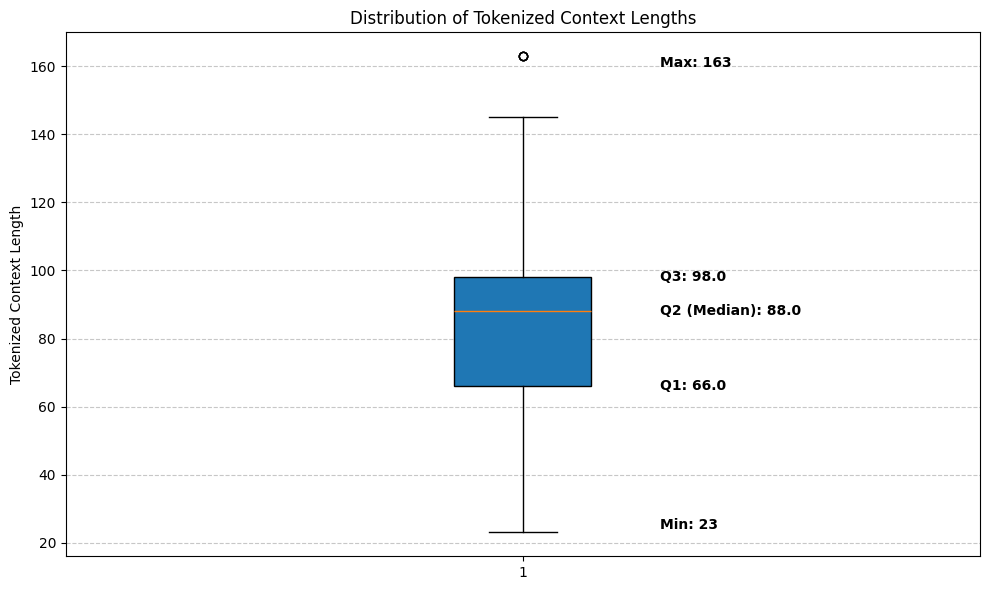

In [21]:
# Visualizing the distribution of tokenized question lengths
context_lengths = [len(tokenizer.encode(sample["context"])[0]) for sample in train_dataset]
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(context_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Context Lengths")
plt.ylabel("Tokenized Context Length")

# Calculate and display quartiles
quartiles = np.percentile(context_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(context_lengths)
max_val = np.max(context_lengths)

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}',
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}',
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}',
         verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}',
         verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}',
         verticalalignment='top', fontweight='bold')

print(f"Summary Statistics for Context Lengths:")
print("Number of questions:", len(context_lengths))
print("Number of outliers:", len([x for x in context_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in context_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Summary Statistics for Question Lengths:
Number of questions: 20000
Number of outliers: 716
Minimum: 6
Q1 (25%): 11.0
Median: 13.0
Q3 (75%): 15.0
Maximum: 42
Interquartile Range (IQR): 4.0
95th Percentile: 21.0
97th Percentile: 22.0
99th Percentile: 25.0


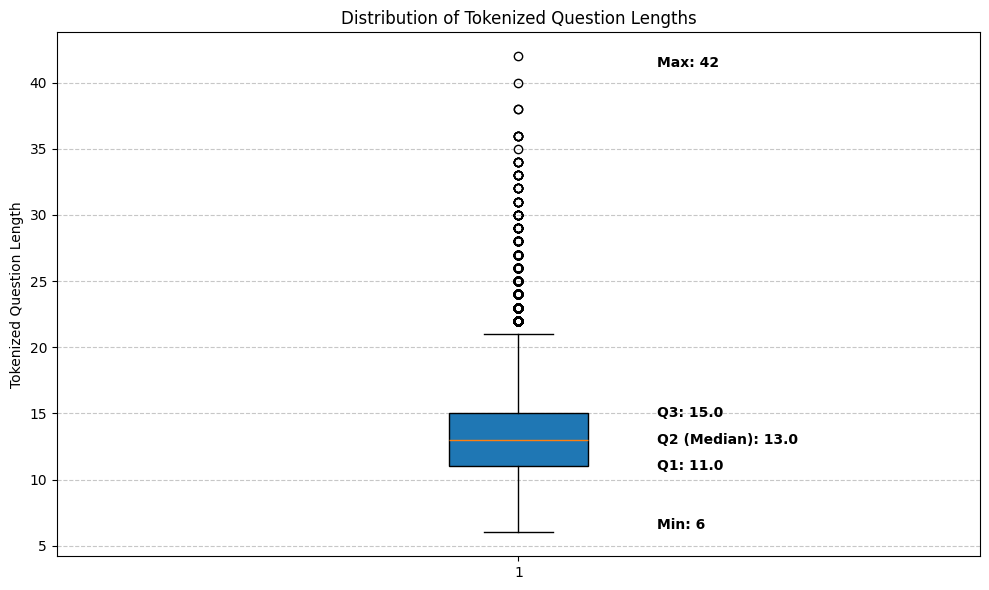

In [22]:
# Visualizing the distribution of tokenized question lengths
question_lengths = [len(tokenizer.encode(sample["question"])[0]) for sample in train_dataset]
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(question_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Question Lengths")
plt.ylabel("Tokenized Question Length")

# Calculate and display quartiles
quartiles = np.percentile(question_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(question_lengths)
max_val = np.max(question_lengths)

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}',
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}',
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}',
         verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}',
         verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}',
         verticalalignment='top', fontweight='bold')

print(f"Summary Statistics for Question Lengths:")
print("Number of questions:", len(question_lengths))
print("Number of outliers:", len([x for x in question_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in question_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Summary Statistics for Answer Lengths:
Number of answers:  20000
Number of outliers:  1822
Minimum: 3
Q1 (25%): 3.0
Median: 4.0
Q3 (75%): 5.0
Maximum: 37
Interquartile Range (IQR): 2.0
95th Percentile: 11.0
97th Percentile: 14.0
99th Percentile: 20.0


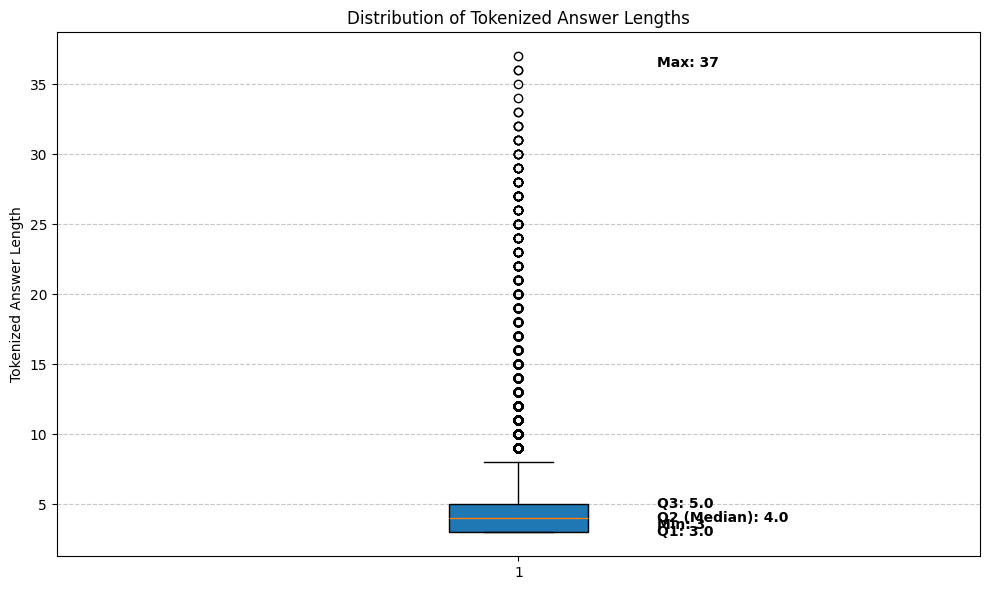

In [23]:
# Visualizing the distribution of tokenized answer lengths
answer_lengths = [len(tokenizer.encode(sample["answer"])[0]) for sample in train_dataset]

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(answer_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Answer Lengths")
plt.ylabel("Tokenized Answer Length")
# Calculate and display quartiles
quartiles = np.percentile(answer_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(answer_lengths)
max_val = np.max(answer_lengths)

print(f"Summary Statistics for Answer Lengths:")
print("Number of answers: ", len(answer_lengths))
print("Number of outliers: ", len([x for x in answer_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in answer_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}',
            verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}',
            verticalalignment='top', fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Summary Statistics for context + question Lengths:
Number of context + question:  20000
Number of outliers:  4
Minimum: 31
Q1 (25%): 78.0
Median: 100.0
Q3 (75%): 111.0
Maximum: 173
Interquartile Range (IQR): 33.0
95th Percentile: 122.0
97th Percentile: 125.0
99th Percentile: 133.0


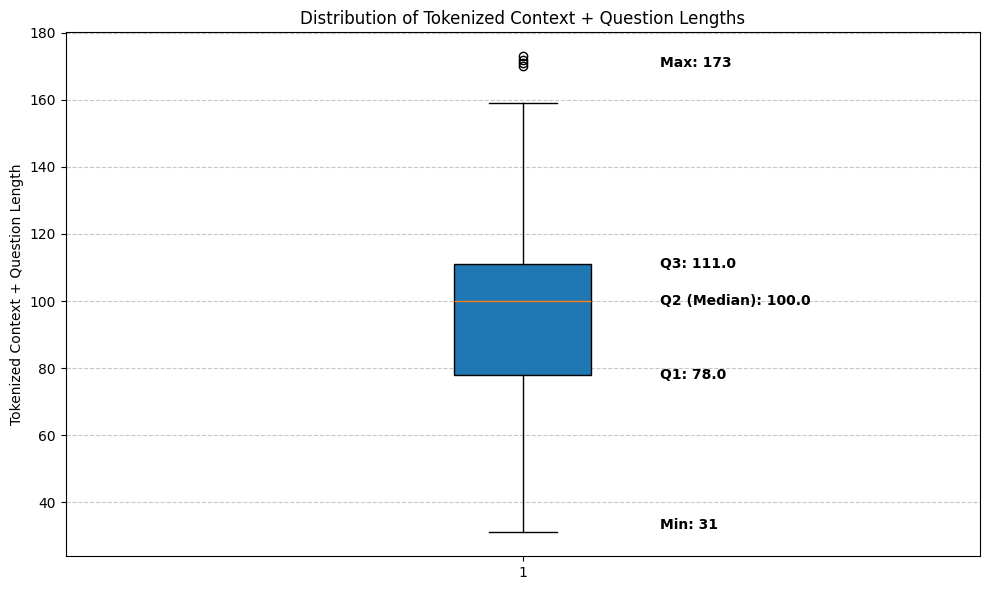

In [24]:
# Visualizing the distribution of tokenized answer lengths
context_question_lengths = [len(tokenizer.encode_two_texts(sample["context"], sample["question"])[0]) for sample in train_dataset]

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(context_question_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Context + Question Lengths")
plt.ylabel("Tokenized Context + Question Length")
# Calculate and display quartiles
quartiles = np.percentile(context_question_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(context_question_lengths)
max_val = np.max(context_question_lengths)

print(f"Summary Statistics for context + question Lengths:")
print("Number of context + question: ", len(context_question_lengths))
print("Number of outliers: ", len([x for x in context_question_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in context_question_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}',
            verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}',
            verticalalignment='top', fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

So for the transformer based models we can use the max length of the question and answer as follows:
1. `Answers Max Length`: 25 tokens
2. `Question Max Length`: 30 tokens
3. `Context Max Length`: 160 tokens
4. `Context + Question Length`: 160+30+1 (+1 for [SEP]) We could have used 175 as it is the 99th percentile but we will use 191 instead


This would give us a good tradeoff between the length of the sequence without using a lot of padding.

In [56]:
# Creating dataset
tokenizer = GloveTokenizer()
train_data = load_and_process_squad("data/m2_train.json", max_samples=20000)
dev_data = load_and_process_squad("data/m2_dev.json", max_samples=2000)

context_max_length = 160
question_max_length = 30
answer_max_length = 25
train_dataset = QADatasetGlove(train_data, tokenizer, context_max_length=context_max_length, question_max_length=question_max_length, answer_max_length=answer_max_length, include_context=True, encode_two_texts=True)
dev_dataset = QADatasetGlove(dev_data, tokenizer, context_max_length=context_max_length, question_max_length=question_max_length, answer_max_length=answer_max_length, include_context=True, encode_two_texts=True)
print("Number of training samples:", len(train_dataset))
print("Number of dev samples:", len(dev_dataset))

# View a sample from the dataset
random_idx = np.random.randint(0, len(train_dataset))
print("Sample from the dataset:")
print("Question encoded:", train_dataset[random_idx]["question"])
print("Question decoded: ", tokenizer.decode(train_dataset[random_idx]["question"]))
print("Answer encoded:", train_dataset[random_idx]["answer"])
print("Answer decoded: ", tokenizer.decode(train_dataset[random_idx]["answer"]))
print("Context encoded:", train_dataset[random_idx]["context"])
print("Context decoded: ", tokenizer.decode(train_dataset[random_idx]["context"]))
print("\n\n")

# View a sample from the dev dataset
random_idx = np.random.randint(0, len(dev_dataset))
print("Sample from the dev dataset:")
print("Context encoded:", dev_dataset[random_idx]["context"])
print("Context decoded: ", tokenizer.decode(dev_dataset[random_idx]["context"]))
print("Question encoded:", dev_dataset[random_idx]["question"])
print("Question decoded: ", tokenizer.decode(dev_dataset[random_idx]["question"]))
print("Answer encoded:", dev_dataset[random_idx]["answer"])
print("Answer decoded: ", tokenizer.decode(dev_dataset[random_idx]["answer"]))
print("Context Question encoded:", dev_dataset[random_idx]["context_question"])
print("Context Question decoded: ", tokenizer.decode(dev_dataset[random_idx]["context_question"]))
print("Answer Start:", dev_dataset[random_idx]["answer_start"])
print("Answer End:", dev_dataset[random_idx]["answer_end"])
print("Answer Start: End decoded:", tokenizer.decode(dev_dataset[random_idx]["context"][dev_dataset[random_idx]["answer_start"]:dev_dataset[random_idx]["answer_end"]+1]))


Filtered dataset size: 19282 out of original 20000
Filtered dataset size: 1917 out of original 2000
Number of training samples: 19282
Number of dev samples: 1917
Sample from the dataset:
Question encoded: tensor([    3,    11,   107,    67,    40,    68,   414,     6, 21469,  5726,
           11,     0,  6252,   465,   193,     4,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])
Question decoded:  in what year were there 4 , 470 priests in dominican order ?
Answer encoded: tensor([   3, 1284,    4,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1])
Answer decoded:  2013
Context encoded: tensor([    3,   110,    42,  1631,   571,     6,     0,   228,     8, 24852,
         1353,   337,     9,    38, 10561,  1273,   319,     6,  1389,     7,
         2386,    15, 10724,   278,   319,     6, 58771,     6,    39,  1389,
            8,  

In [58]:
# Creating Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True) # add this `num_workers=0` if you want to see print in __getitem__ in dataset class
dev_dataloader = DataLoader(dev_dataset, batch_size=64, shuffle=False)

# for batch in train_dataloader:
#     print(batch.keys())
#     print(batch['context_question'][0])
#     print(batch['question'].shape)
#     # print(batch['answer'].shape)
#     print(batch['attention_mask_context_question'][0])

#     # print(batch['attention_mask_answer'].shape)
#     # print(batch['attention_mask_context_question'].shape)
#     # print(batch['answer_start'], batch['answer_end'])
#     print("-" * 50)

### 5. Phase 1: Model Training

#### Question [SEP] Context

In [59]:
print(tokenizer.get_pretrained_embeddings().shape)

torch.Size([400006, 300])


In [60]:

def train_qa_context_model(model: nn.Module,
                           train_dataloader: DataLoader,
                           criterion: nn.Module,
                           optimizer: optim.Optimizer,
                           device: torch.device,
                           num_epochs: int,
                           val_dataloader: DataLoader=None,
                           evaluate_val_dataset: bool=False) -> None:
    """
    Train and evaluate the QA context model.

    Args:
        model (nn.Module): The model to train.
        train_dataloader (DataLoader): DataLoader for training data.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer.
        device (torch.device): Device to train on (CPU or GPU).
        num_epochs (int): Number of epochs to train for.
        val_dataloader (DataLoader, optional): DataLoader for validation data.
        evaluate_val_dataset (bool): Whether to evaluate on the validation dataset after each epoch.

    """
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            context_question = batch['context_question'].to(device)
            answer_start = batch['answer_start'].contiguous().view(-1).to(device)
            answer_end = batch['answer_end'].contiguous().view(-1).to(device)
            optimizer.zero_grad()

            # Forward pass
            start_logits, end_logits = model(context_question)

            start_logits = start_logits.contiguous().view(-1, start_logits.size(-1))
            end_logits = end_logits.contiguous().view(-1, end_logits.size(-1))

            # print startlogits argmax
            print("argmax start logits:", start_logits.argmax(dim=-1))
            print("argmax end logits :", end_logits.argmax(dim=-1))

            # print actual values
            print("answer start:", answer_start)
            print("answer end:", answer_end)

            loss_start = criterion(start_logits, answer_start)
            loss_end = criterion(end_logits, answer_end)
            loss = loss_start + loss_end

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} Loss: {epoch_loss / len(train_dataloader):.4f}")

        train_metrics = evaluate_qa_context_model(model, train_dataloader, criterion, device, prefix_str="Training")
        if evaluate_val_dataset and val_dataloader is not None:
            val_metrics = evaluate_qa_context_model(model, val_dataloader, criterion, device)
        print('-'*50)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pad_idx=1

model = model = TransformerQAModel3(
    vocab_size=10_000,
    d_model=300,
    num_layers=4,
    num_heads=6,
    dim_feedforward=512,
    max_question_len=30,
    max_context_len=160,
    dropout=0.01,
    pretrained_embeddings= tokenizer.get_pretrained_embeddings(),
    freeze_embeddings=True,
)
model = model.to(device)

# Setup an optimizer (e.g., Adam)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_qa_context_model_boilerplate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=dev_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=10,
    device=device,
    inputs = ["context_question", "attention_mask_context_question"],
    evaluate_val_dataset=True,
)


Epoch 1/10: 100%|██████████| 302/302 [01:20<00:00,  3.76it/s, loss=7.03]


Epoch 1 Loss: 8.1885


Evaluating: 100%|██████████| 302/302 [00:58<00:00,  5.19it/s]


Training Loss: 7.6132
Training Metrics: {'start_accuracy': 0.10750959444041075, 'start_precision': 0.11058303957773774, 'start_recall': 0.10750959444041075, 'start_f1_score': 0.10711963244586324, 'end_accuracy': 0.1097396535629084, 'end_precision': 0.11492701333986183, 'end_recall': 0.1097396535629084, 'end_f1_score': 0.10986435742011155, 'joint_exact_match': np.float64(0.07711855616637278), 'span_overlap_f1': np.float64(0.0891646314122368)}


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Validation Loss: 8.6513
Validation Metrics: {'start_accuracy': 0.06155451225873761, 'start_precision': 0.06531990183898656, 'start_recall': 0.06155451225873761, 'start_f1_score': 0.0596471391919189, 'end_accuracy': 0.057902973395931145, 'end_precision': 0.061813839732729574, 'end_recall': 0.057902973395931145, 'end_f1_score': 0.056689332283597633, 'joint_exact_match': np.float64(0.038601982263954095), 'span_overlap_f1': np.float64(0.05090056577534131)}
--------------------------------------------------


Epoch 2/10: 100%|██████████| 302/302 [01:20<00:00,  3.76it/s, loss=7.03]


Epoch 2 Loss: 7.4366


Evaluating: 100%|██████████| 302/302 [00:58<00:00,  5.17it/s]


Training Loss: 7.0877
Training Metrics: {'start_accuracy': 0.14505756664246447, 'start_precision': 0.14671351246734146, 'start_recall': 0.14505756664246447, 'start_f1_score': 0.143898461203112, 'end_accuracy': 0.15423711233274556, 'end_precision': 0.1574339594623694, 'end_recall': 0.15423711233274556, 'end_f1_score': 0.15366435567343803, 'joint_exact_match': np.float64(0.1147183902084846), 'span_overlap_f1': np.float64(0.12725519660771165)}


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.88it/s]


Validation Loss: 8.1551
Validation Metrics: {'start_accuracy': 0.08398539384454877, 'start_precision': 0.11589545198282734, 'start_recall': 0.08398539384454877, 'start_f1_score': 0.0836967454297007, 'end_accuracy': 0.09285341679707877, 'end_precision': 0.10791268233366438, 'end_recall': 0.09285341679707877, 'end_f1_score': 0.0926794939456587, 'joint_exact_match': np.float64(0.06103286384976526), 'span_overlap_f1': np.float64(0.07596491319939662)}
--------------------------------------------------


Epoch 3/10: 100%|██████████| 302/302 [01:20<00:00,  3.76it/s, loss=7.32]


Epoch 3 Loss: 7.0678


Evaluating: 100%|██████████| 302/302 [00:57<00:00,  5.26it/s]


Training Loss: 6.9683
Training Metrics: {'start_accuracy': 0.16025308577948347, 'start_precision': 0.16047649807750985, 'start_recall': 0.16025308577948347, 'start_f1_score': 0.15849891460303941, 'end_accuracy': 0.16886215122912562, 'end_precision': 0.17162854015422072, 'end_recall': 0.16886215122912562, 'end_f1_score': 0.16784567497425032, 'joint_exact_match': np.float64(0.12758012654288975), 'span_overlap_f1': np.float64(0.14133236618345815)}


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


Validation Loss: 8.2953
Validation Metrics: {'start_accuracy': 0.08555033907146584, 'start_precision': 0.09190570529375769, 'start_recall': 0.08555033907146584, 'start_f1_score': 0.0826467466136295, 'end_accuracy': 0.09285341679707877, 'end_precision': 0.10060844301704612, 'end_recall': 0.09285341679707877, 'end_f1_score': 0.09077135003694137, 'joint_exact_match': np.float64(0.06468440271257173), 'span_overlap_f1': np.float64(0.07791271672007828)}
--------------------------------------------------


Epoch 4/10: 100%|██████████| 302/302 [01:19<00:00,  3.78it/s, loss=5.7]


Epoch 4 Loss: 6.8569


Evaluating: 100%|██████████| 302/302 [00:59<00:00,  5.10it/s]


Training Loss: 6.5827
Training Metrics: {'start_accuracy': 0.1748262628358054, 'start_precision': 0.17565526150017116, 'start_recall': 0.1748262628358054, 'start_f1_score': 0.17316801160745446, 'end_accuracy': 0.18317601908515715, 'end_precision': 0.1862142508491909, 'end_recall': 0.18317601908515715, 'end_f1_score': 0.18247064436863936, 'joint_exact_match': np.float64(0.1394046260761332), 'span_overlap_f1': np.float64(0.154045049893984)}


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.48it/s]


Validation Loss: 8.3862
Validation Metrics: {'start_accuracy': 0.08659363588941053, 'start_precision': 0.100642886336934, 'start_recall': 0.08659363588941053, 'start_f1_score': 0.08474729297406071, 'end_accuracy': 0.10067814293166406, 'end_precision': 0.10659403583764225, 'end_recall': 0.10067814293166406, 'end_f1_score': 0.0984429680795777, 'joint_exact_match': np.float64(0.06520605112154408), 'span_overlap_f1': np.float64(0.07885825382549957)}
--------------------------------------------------


Epoch 5/10: 100%|██████████| 302/302 [01:20<00:00,  3.74it/s, loss=6.41]


Epoch 5 Loss: 6.7056


Evaluating: 100%|██████████| 302/302 [00:59<00:00,  5.06it/s]


Training Loss: 6.5203
Training Metrics: {'start_accuracy': 0.18136085468312416, 'start_precision': 0.18176932539483207, 'start_recall': 0.18136085468312416, 'start_f1_score': 0.17941971638214319, 'end_accuracy': 0.18691007156933928, 'end_precision': 0.18956670540584258, 'end_recall': 0.18691007156933928, 'end_f1_score': 0.18580496687433767, 'joint_exact_match': np.float64(0.14630225080385853), 'span_overlap_f1': np.float64(0.16113065201743948)}


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s]


Validation Loss: 8.4170
Validation Metrics: {'start_accuracy': 0.09285341679707877, 'start_precision': 0.09937071810878503, 'start_recall': 0.09285341679707877, 'start_f1_score': 0.09109623864001037, 'end_accuracy': 0.0892018779342723, 'end_precision': 0.09774592753069192, 'end_recall': 0.0892018779342723, 'end_f1_score': 0.08790522989153743, 'joint_exact_match': np.float64(0.0683359415753782), 'span_overlap_f1': np.float64(0.08199467248743016)}
--------------------------------------------------


Epoch 6/10: 100%|██████████| 302/302 [01:21<00:00,  3.68it/s, loss=5.63]


Epoch 6 Loss: 6.6235


Evaluating: 100%|██████████| 302/302 [01:05<00:00,  4.61it/s]


Training Loss: 6.4731
Training Metrics: {'start_accuracy': 0.18499118348719013, 'start_precision': 0.18585417583096556, 'start_recall': 0.18499118348719013, 'start_f1_score': 0.18324304094547766, 'end_accuracy': 0.18779172285032672, 'end_precision': 0.19029769007390834, 'end_recall': 0.18779172285032672, 'end_f1_score': 0.18661922273061698, 'joint_exact_match': np.float64(0.15008816512809875), 'span_overlap_f1': np.float64(0.1635201508821343)}


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.73it/s]


Validation Loss: 8.4574
Validation Metrics: {'start_accuracy': 0.10224308815858112, 'start_precision': 0.1210336590972836, 'start_recall': 0.10224308815858112, 'start_f1_score': 0.10262289249114907, 'end_accuracy': 0.10537297861241524, 'end_precision': 0.12033225097824211, 'end_recall': 0.10537297861241524, 'end_f1_score': 0.10644219875273361, 'joint_exact_match': np.float64(0.08085550339071466), 'span_overlap_f1': np.float64(0.09340957890064615)}
--------------------------------------------------


Epoch 7/10: 100%|██████████| 302/302 [01:21<00:00,  3.69it/s, loss=7.01]


Epoch 7 Loss: 6.5276


Evaluating: 100%|██████████| 302/302 [00:58<00:00,  5.13it/s]


Training Loss: 6.3886
Training Metrics: {'start_accuracy': 0.18779172285032672, 'start_precision': 0.18744463478447196, 'start_recall': 0.18779172285032672, 'start_f1_score': 0.18518053823443142, 'end_accuracy': 0.1934965252567161, 'end_precision': 0.19519560373421577, 'end_recall': 0.1934965252567161, 'end_f1_score': 0.1913017150239472, 'joint_exact_match': np.float64(0.15957888185872834), 'span_overlap_f1': np.float64(0.1731795754942546)}


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


Validation Loss: 8.0207
Validation Metrics: {'start_accuracy': 0.08763693270735524, 'start_precision': 0.09012815725229899, 'start_recall': 0.08763693270735524, 'start_f1_score': 0.08422543096729347, 'end_accuracy': 0.09181011997913406, 'end_precision': 0.1036272122261673, 'end_recall': 0.09181011997913406, 'end_f1_score': 0.09186294622149242, 'joint_exact_match': np.float64(0.0683359415753782), 'span_overlap_f1': np.float64(0.08076155294404985)}
--------------------------------------------------


Epoch 8/10: 100%|██████████| 302/302 [01:21<00:00,  3.68it/s, loss=7.35]


Epoch 8 Loss: 6.4440


Evaluating: 100%|██████████| 302/302 [00:59<00:00,  5.05it/s]


Training Loss: 6.2851
Training Metrics: {'start_accuracy': 0.1973861632610725, 'start_precision': 0.1977641744728771, 'start_recall': 0.1973861632610725, 'start_f1_score': 0.19532113655763847, 'end_accuracy': 0.20490613006949487, 'end_precision': 0.2079943424300104, 'end_recall': 0.20490613006949487, 'end_f1_score': 0.20394778350221196, 'joint_exact_match': np.float64(0.1565190332953013), 'span_overlap_f1': np.float64(0.17122160506001108)}


Evaluating: 100%|██████████| 30/30 [00:06<00:00,  4.84it/s]


Validation Loss: 8.0776
Validation Metrics: {'start_accuracy': 0.0980699008868023, 'start_precision': 0.11225707175794855, 'start_recall': 0.0980699008868023, 'start_f1_score': 0.09637393348826935, 'end_accuracy': 0.1090245174752217, 'end_precision': 0.11890507893433798, 'end_recall': 0.1090245174752217, 'end_f1_score': 0.10655911932422292, 'joint_exact_match': np.float64(0.07407407407407407), 'span_overlap_f1': np.float64(0.08931356635479791)}
--------------------------------------------------


Epoch 9/10: 100%|██████████| 302/302 [01:21<00:00,  3.72it/s, loss=5.51]


Epoch 9 Loss: 6.3931


Evaluating: 100%|██████████| 302/302 [00:59<00:00,  5.06it/s]


Training Loss: 6.2130
Training Metrics: {'start_accuracy': 0.19645265014002697, 'start_precision': 0.19599842996365027, 'start_recall': 0.19645265014002697, 'start_f1_score': 0.194368085474412, 'end_accuracy': 0.20319468934757806, 'end_precision': 0.204898455382994, 'end_recall': 0.20319468934757806, 'end_f1_score': 0.20190623061551427, 'joint_exact_match': np.float64(0.16269059226221347), 'span_overlap_f1': np.float64(0.17840599551187744)}


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.79it/s]


Validation Loss: 8.3745
Validation Metrics: {'start_accuracy': 0.09650495565988523, 'start_precision': 0.11006834253946562, 'start_recall': 0.09650495565988523, 'start_f1_score': 0.09391202667772289, 'end_accuracy': 0.1011997913406364, 'end_precision': 0.10671939619089249, 'end_recall': 0.1011997913406364, 'end_f1_score': 0.09880994066131196, 'joint_exact_match': np.float64(0.07198748043818466), 'span_overlap_f1': np.float64(0.08792875305772402)}
--------------------------------------------------


Epoch 10/10: 100%|██████████| 302/302 [01:21<00:00,  3.70it/s, loss=6.31]


Epoch 10 Loss: 6.3112


Evaluating: 100%|██████████| 302/302 [00:59<00:00,  5.08it/s]


Training Loss: 6.1742
Training Metrics: {'start_accuracy': 0.2016388341458355, 'start_precision': 0.2030179312729945, 'start_recall': 0.2016388341458355, 'start_f1_score': 0.19909234524370853, 'end_accuracy': 0.208640182553677, 'end_precision': 0.2106932030773379, 'end_recall': 0.208640182553677, 'end_f1_score': 0.20694604795007676, 'joint_exact_match': np.float64(0.16237942122186494), 'span_overlap_f1': np.float64(0.1770366263235481)}


Evaluating: 100%|██████████| 30/30 [00:06<00:00,  4.94it/s]

Validation Loss: 8.2752
Validation Metrics: {'start_accuracy': 0.099113197704747, 'start_precision': 0.10707958533766497, 'start_recall': 0.099113197704747, 'start_f1_score': 0.09782463506630618, 'end_accuracy': 0.107981220657277, 'end_precision': 0.11370135611034472, 'end_recall': 0.107981220657277, 'end_f1_score': 0.10448899299108468, 'joint_exact_match': np.float64(0.07303077725612937), 'span_overlap_f1': np.float64(0.08766103331974807)}
--------------------------------------------------


In [ ]:
model_path = "models/glove_qa_context_model_transformer.pkl"

In [68]:
save_model(model, model_path)

Model saved to glove_qa_context_model_transformer.pkl


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model(model_path=model_path)

In [ ]:
# evaluate the model on the dev set
criterion = nn.CrossEntropyLoss(ignore_index=1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
evaluate_qa_context_model(model=model, dataloader=train_dataloader, criterion=criterion, device=device)

Evaluating: 100%|██████████| 623/623 [02:40<00:00,  3.87it/s]

Validation Loss: 8.3085
Validation Metrics: {'start_accuracy': 0.05107985936715218, 'start_precision': 0.0210278048402632, 'start_recall': 0.05107985936715218, 'start_f1_score': 0.017836301387035493, 'end_accuracy': 0.038774485183324964, 'end_precision': 0.02625939398540667, 'end_recall': 0.038774485183324964, 'end_f1_score': 0.014548191172049172, 'joint_exact_match': np.float64(0.01210447011551984), 'span_overlap_f1': np.float64(0.07486644192790155)}


(8.308501643124208,
 {'start_accuracy': 0.05107985936715218,
  'start_precision': 0.0210278048402632,
  'start_recall': 0.05107985936715218,
  'start_f1_score': 0.017836301387035493,
  'end_accuracy': 0.038774485183324964,
  'end_precision': 0.02625939398540667,
  'end_recall': 0.038774485183324964,
  'end_f1_score': 0.014548191172049172,
  'joint_exact_match': np.float64(0.01210447011551984),
  'span_overlap_f1': np.float64(0.07486644192790155)})

In [ ]:
# evaluate the model on the dev set
criterion = nn.CrossEntropyLoss(ignore_index=1)
evaluate_qa_context_model(model=model, dataloader=dev_dataloader, criterion=criterion, device=device)

Evaluating: 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]

Validation Loss: 9.5070
Validation Metrics: {'start_accuracy': 0.023127199597787834, 'start_precision': 0.005413506445485052, 'start_recall': 0.023127199597787834, 'start_f1_score': 0.00600477968456967, 'end_accuracy': 0.010558069381598794, 'end_precision': 0.005830250742126152, 'end_recall': 0.010558069381598794, 'end_f1_score': 0.0045738449136539395, 'joint_exact_match': np.float64(0.002011060834590246), 'span_overlap_f1': np.float64(0.037480056586296204)}


(9.507018573700435,
 {'start_accuracy': 0.023127199597787834,
  'start_precision': 0.005413506445485052,
  'start_recall': 0.023127199597787834,
  'start_f1_score': 0.00600477968456967,
  'end_accuracy': 0.010558069381598794,
  'end_precision': 0.005830250742126152,
  'end_recall': 0.010558069381598794,
  'end_f1_score': 0.0045738449136539395,
  'joint_exact_match': np.float64(0.002011060834590246),
  'span_overlap_f1': np.float64(0.037480056586296204)})

In [ ]:
preds, true_labels = predict_qa_context_model(model=model, dataloader=dev_dataloader, tokenizer=tokenizer, device=device)

Predicting: 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


In [ ]:
# Compare the predictions with the actual answers
for i in range(100):
    print(f"Predicted Answer: {preds[i]}")
    print(f"True Answer: {true_labels[i]}")
    print("-" * 50)

Predicted Answer: rugby is also
True Answer: rugby
--------------------------------------------------
Predicted Answer: rugby is also
True Answer: an official school sport
--------------------------------------------------
Predicted Answer: rugby is also
True Answer: high school
--------------------------------------------------
Predicted Answer: of course ,
True Answer: framework
--------------------------------------------------
Predicted Answer: of course ,
True Answer: complexity classes
--------------------------------------------------
Predicted Answer: 
True Answer: complicated definitions
--------------------------------------------------
Predicted Answer: many locals and
True Answer: palm springs
--------------------------------------------------
Predicted Answer: many locals and tourists frequent southern california coast for its popular beaches , and
True Answer: southern
--------------------------------------------------
Predicted Answer: 
True Answer: open spaces
---------

In [ ]:
train_preds, train_true_labels = predict_qa_context_model(model=model, dataloader=train_dataloader, tokenizer=tokenizer, device=device)

Predicting: 100%|██████████| 623/623 [01:55<00:00,  5.41it/s]


In [ ]:
# Compare the predictions with the actual answers
for i in range(100):
    print(f"Predicted Answer: {train_preds[i]}")
    print(f"True Answer: {train_true_labels[i]}")
    print("-" * 50)

Predicted Answer: not get
True Answer: symbiotic companion plant relationships
--------------------------------------------------
Predicted Answer: eastern mediterranean .
True Answer: ottoman empire
--------------------------------------------------
Predicted Answer: , but is now generally made of synthetic materials .
True Answer: fiberglass
--------------------------------------------------
Predicted Answer: symbiosis ( from greek together and living ) is
True Answer: greek
--------------------------------------------------
Predicted Answer: first
True Answer: 1938
--------------------------------------------------
Predicted Answer: through section 2054 . 116 of government
True Answer: websites in spanish to assist residents who have limited english proficiency .
--------------------------------------------------
Predicted Answer: solar
True Answer: sh
--------------------------------------------------
Predicted Answer: former soviet states , present-day
True Answer: around 5 millio